Detecting Cracks On Surfaces
---

We will use a TensorFlow **Convolutional Neural Network (CNN)** to make the predictions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.simplefilter("ignore")

2024-08-20 08:25:56.635858: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 08:25:56.636025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 08:25:56.816852: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Turn the directory paths into Path object
positive_dir = Path('../input/surface-crack-detection/Positive')
negative_dir = Path('../input/surface-crack-detection/Negative')

# Create DataFrame

Let's create a DataFrame containing the path of the image and the associated label. This will permit to flow the images from it.

In [3]:
def generate_df(image_dir, label):
    """
    Create the DataFrame of the associated directory and label.
    """
    
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    
    return df

In [4]:
# Check Positive DataFrame
positive_df = generate_df(positive_dir, 'POSITIVE')
positive_df.head()

,Filepath,Label
0,../input/surface-crack-detection/Positive/0845...,POSITIVE
1,../input/surface-crack-detection/Positive/1981...,POSITIVE
2,../input/surface-crack-detection/Positive/0593...,POSITIVE
3,../input/surface-crack-detection/Positive/0612...,POSITIVE
4,../input/surface-crack-detection/Positive/0853...,POSITIVE


In [5]:
# Check Negative DataFrame
negative_df = generate_df(negative_dir, 'NEGATIVE')
negative_df.head()

,Filepath,Label
0,../input/surface-crack-detection/Negative/0845...,NEGATIVE
1,../input/surface-crack-detection/Negative/1981...,NEGATIVE
2,../input/surface-crack-detection/Negative/1691...,NEGATIVE
3,../input/surface-crack-detection/Negative/0593...,NEGATIVE
4,../input/surface-crack-detection/Negative/0612...,NEGATIVE


In [6]:
# Concatenate DataFrame (on top of each other)
data = pd.concat([positive_df, negative_df], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
data.head()

,Filepath,Label
0,../input/surface-crack-detection/Negative/1235...,NEGATIVE
1,../input/surface-crack-detection/Positive/0567...,POSITIVE
2,../input/surface-crack-detection/Negative/0704...,NEGATIVE
3,../input/surface-crack-detection/Positive/0417...,POSITIVE
4,../input/surface-crack-detection/Negative/1816...,NEGATIVE


In [7]:
# Split Training and Test sets
train_df, test_df = train_test_split(
    data.sample(6000, random_state=1), # Keep only 6000 samples to save computation time.
    train_size=0.7,
    shuffle=True,
    random_state=42)

# Loading Image Data

In [8]:
# Image generator for the training set
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2,
)

# Image generator for the test set
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255
)

In [9]:
# Generate training images
train_images = train_generator.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

# Generate validation images
val_images = train_generator.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

# Generate test images
test_images = test_generator.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


# Training

In [10]:
# Create the layers
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [11]:
# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 118, 118, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,953 (101.38 KB)

 Trainable params: 25,953 (101.38 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [13]:
# History
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 37s 316ms/step - accuracy: 0.5198 - loss: 0.6922 - val_accuracy: 0.7369 - val_loss: 0.6643
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 179ms/step - accuracy: 0.7234 - loss: 0.5775 - val_accuracy: 0.9143 - val_loss: 0.2364
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 182ms/step - accuracy: 0.9422 - loss: 0.1802 - val_accuracy: 0.9619 - val_loss: 0.1355
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - accuracy: 0.9666 - loss: 0.1046 - val_accuracy: 0.9750 - val_loss: 0.0966
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - accuracy: 0.9783 - loss: 0.0750 - val_accuracy: 0.9655 - val_loss: 0.1451
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.9802 - loss: 0.0546 - val_accuracy: 0.9786 - val_loss: 0.0854
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 176ms/step - accuracy: 0.9766 - loss: 0.0729 - val_accuracy: 0.9762 - val_loss: 0.0710
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 180ms/step - accuracy: 0.9847 -

In [14]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epochs", 'value':"Loss"},
    title=("Training and Validation Loss over Time")
)

fig.show()

# Results

In [15]:
y_pred = (model.predict(test_images).squeeze() >= 0.5).astype(int)

def evaluate_model(model):
    
    results = model.evaluate(test_images, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("Test Loss: {:.5f}".format(loss))
    print("Accuracy: {:.2f}%".format(acc * 100))
    
    cm = confusion_matrix(test_images.labels, y_pred)
    clr = classification_report(test_images.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print("Classification Report:\n------------------------------\n", clr)

57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 253ms/step


Test Loss: 0.02764
Accuracy: 99.06%


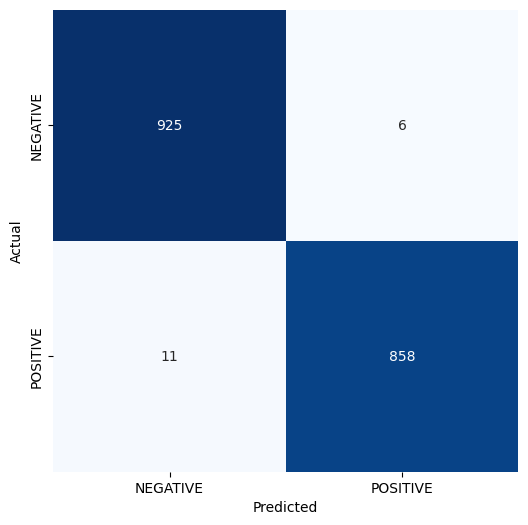

Classification Report:
------------------------------
               precision    recall  f1-score   support

    NEGATIVE       0.99      0.99      0.99       931
    POSITIVE       0.99      0.99      0.99       869

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800



In [16]:
evaluate_model(model)

# Display Results

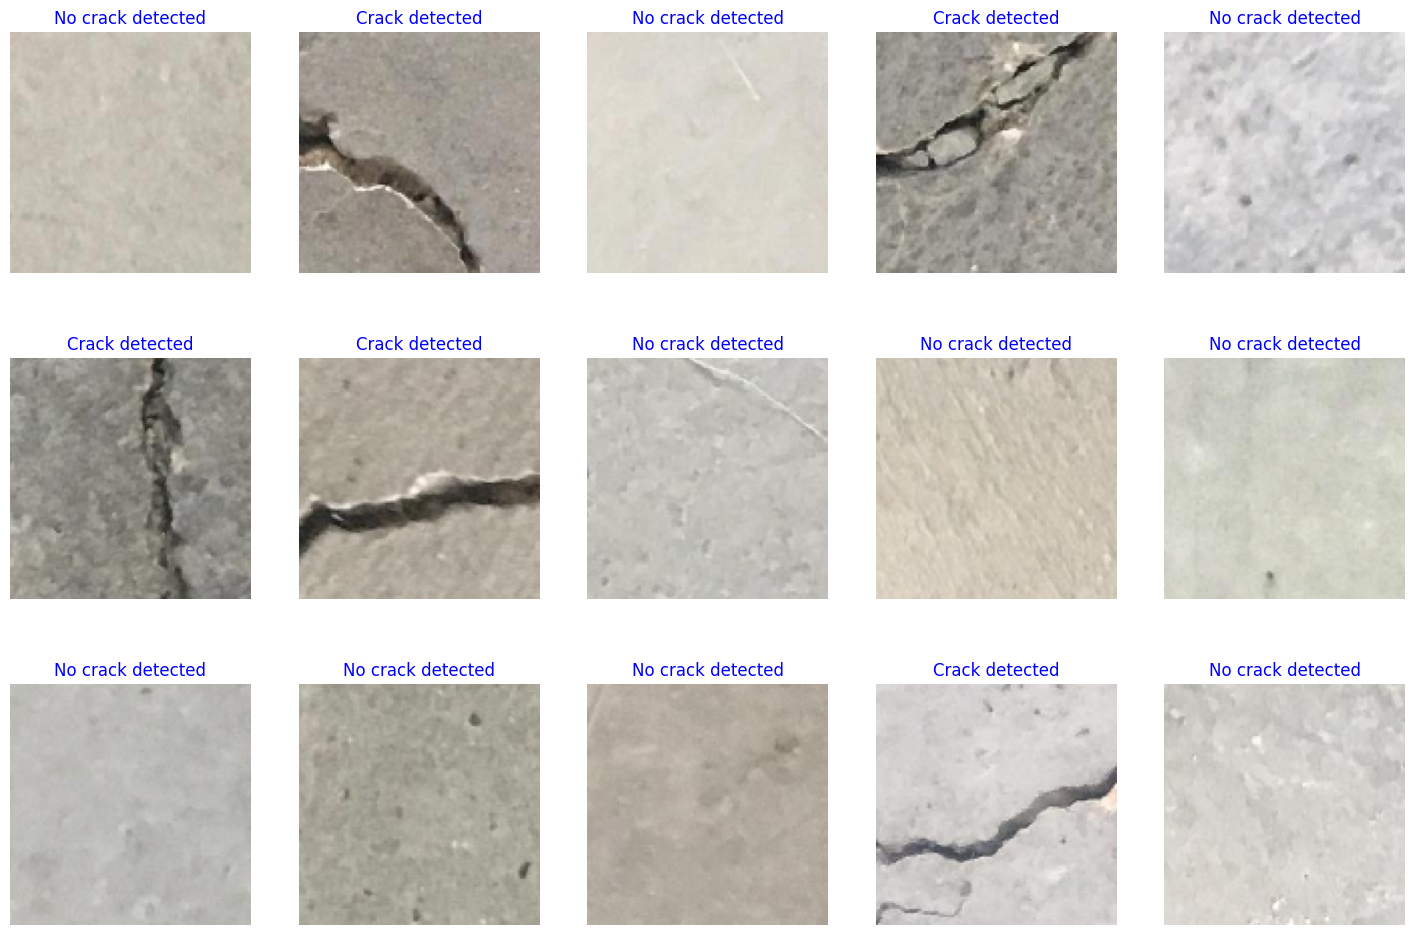

In [17]:
plt.figure(figsize=(18, 12))

for i in range(15):
    
    plt.subplot(3, 5, i+1)
    plt.imshow(test_images[0][0][i])
    plt.title("No crack detected" if y_pred[i] == 0 else "Crack detected",
              color='blue' if y_pred[i] == test_images.labels[i] else 'red')
    plt.axis('off')
    
plt.show()

# Display Mistakes

In [18]:
mistake_idx = (y_pred != test_images.labels).nonzero()[0]
print(len(mistake_idx), "mistakes.")
print("Indices:", mistake_idx)

17 mistakes.
Indices: [  72   87  124  135  230  286  542  679  846 1182 1344 1406 1439 1608
 1619 1632 1770]


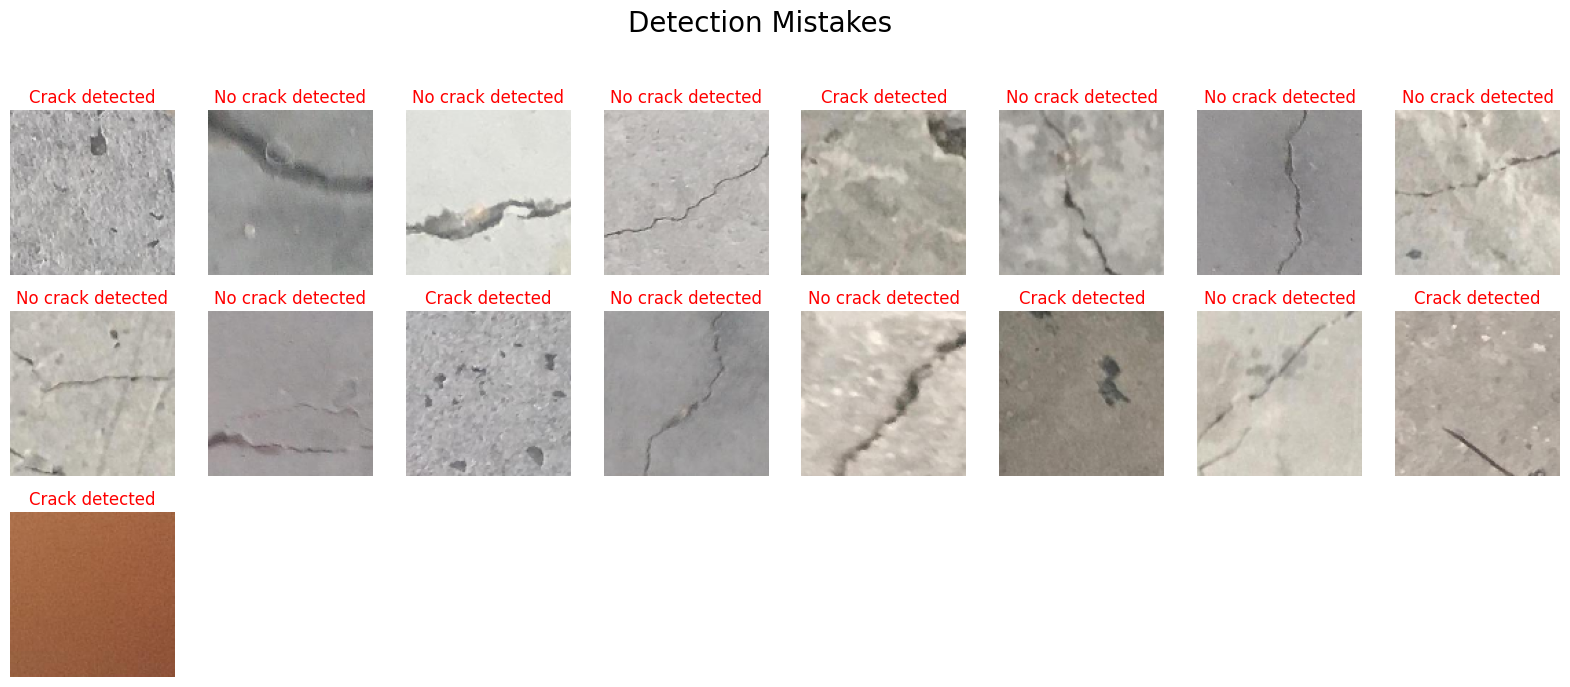

In [19]:
# Display the detection mistakes
plt.figure(figsize=(20, 10))

for i, idx in enumerate(mistake_idx):
    
    # Get batch number and image number (batch of 32 images)
    batch = idx // 32
    image = idx % 32
    
    plt.subplot(4, 8, i+1)
    plt.imshow(test_images[batch][0][image])
    plt.title("No crack detected" if y_pred[idx] == 0 else "Crack detected", color='red')
    plt.axis('off')
    
plt.suptitle("Detection Mistakes", fontsize=20)
plt.show()

Among the 1800 images of the test set, only a few were misclassified.

Not all the images from the dataset have been used.

Results can be even better by devoting more time for training.

---